In [2]:
%matplotlib notebook
import numpy as np
from PIL import Image

import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf
from skimage.transform import downscale_local_mean #For binning

from statistics import median
from statistics import mode

import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

import sys
#sys.path.append("../kai_colloids/PyDDM") #must point to the PyDDM folder
#import ddm_analysis_and_fitting as ddm   
3
import tiff_file 

import io 
import sys
import csv

import os
import glob #glob is helpful for searching for filenames or directories
import pickle #for saving data
### usually this block prints out "nd2reader module not found. Reading of .nd2 files disabled." on the first run
### this is fine (unless you need to read .nd2 files), just re-run this block to make the error go away

In [1]:
def floodfill_flat(array, x, y, rows, cols):
    stack = []
    if array[x,y] != -1:
        return 0
    stack.append((x,y))
    currclustersize = 1
    array[x,y] = -2
    while stack:
        xcurr, ycurr = stack.pop()
        if xcurr > 0:
            if array[xcurr-1,ycurr] == -1:
                array[xcurr-1,ycurr] = -2
                currclustersize += 1
                stack.append((xcurr-1,ycurr))
        if xcurr < rows-1:
            if array[xcurr+1,ycurr] == -1:
                array[xcurr+1,ycurr] = -2
                currclustersize += 1
                stack.append((xcurr+1,ycurr))
        if ycurr > 0:
            if array[xcurr,ycurr-1] == -1:
                array[xcurr,ycurr-1] = -2
                currclustersize += 1
                stack.append((xcurr,ycurr-1))
        if ycurr < cols-1:
            if array[xcurr,ycurr+1] == -1:
                array[xcurr,ycurr+1] = -2
                currclustersize += 1
                stack.append((xcurr,ycurr+1))
    return currclustersize


def markcluster_flat(array, x, y, rows, cols, clustersize):
    stack = []
    if array[x,y] != -2:
        return
    stack.append((x,y))
    array[x,y] = clustersize
    while stack:
        xcurr, ycurr = stack.pop()
        if xcurr > 0:
            if array[xcurr-1,ycurr] == -2:
                array[xcurr-1,ycurr] = clustersize
                stack.append((xcurr-1,ycurr))
        if xcurr < rows-1:
            if array[xcurr+1,ycurr] == -2:
                array[xcurr+1,ycurr] = clustersize
                stack.append((xcurr+1,ycurr))
        if ycurr > 0:
            if array[xcurr,ycurr-1] == -2:
                array[xcurr,ycurr-1] = clustersize
                stack.append((xcurr,ycurr-1))
        if ycurr < cols-1:
            if array[xcurr,ycurr+1] == -2:
                array[xcurr,ycurr+1] = clustersize
                stack.append((xcurr,ycurr+1))
                
def rows_n_cols(im):
    imarray = np.array(im)
    rows, cols = np.shape(imarray)
    return rows, cols

### filtimage removes the background 
def filtimage(image, filtersize=600):
    image = (image/100)**1.6 #(array)^1.6 to increase contrast (i think this works?)
    image = (image*10) +1000
    image = (image*1.0) - ((uf(image,filtersize))*1)  #(image) - unifrom-filtered(image) subtracts background
    image = image + 1500  #return pixel array values back to their original range 
    return image

def threshold_images(fsize, im, i, return_marked, filt):
    if filt == False:
        im = im
    else:
        im = filtimage(im, filtersize= fsize)
    imarray = np.array(im)
    rows, cols = np.shape(imarray)
    sys.setrecursionlimit(rows*cols)
    med = np.median(imarray)
    if frame_key == 2:
        if i == 5:
            imarray = imarray + 0 #5 #20
        if i == 6:
            imarray = imarray + 0 #10 #60
        if i == 7:
            imarray = imarray + 0 #15 #105
        if i > 7:
            imarray = imarray + 0 #20 #125
    thresh = 1.12*med  #1.8*med
    arraythresh = (imarray) > thresh
    threshimage = Image.fromarray(arraythresh)
### mark unclustered pixels with -1
    marked_arraythresh = -1*(imarray > thresh)
    if return_marked == False:
        return threshimage
    if return_marked == True:
        return marked_arraythresh
    #return marked_arraythresh, threshimage

def show_filtered_images(fsize, row, ax, i, frame_key, filt):
    index_add = arr_length * (row -1)
    if time_array[i] == 0:
        empty_im = np.zeros((1440,1920))
        ax.imshow(empty_im, cmap = 'gray')
        ax.set_title('[no image]', fontsize=10)
    elif filt == False:
        raw_image = tiff_file.imread(files[i+index_add],key=[frame_key])
        ax.imshow(raw_image, cmap = 'gray')
        ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+", fsize=none)", fontsize=10)
    else:
        raw_image = tiff_file.imread(files[i+index_add],key=[frame_key])
        filtered_image = filtimage(raw_image, filtersize= fsize)
        ax.imshow(filtered_image, cmap = 'gray')
        ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+", fsize="+str(fsize)+")", fontsize=10)
    ax.axis('off')
    plt.tight_layout(pad=.2)
    
def show_threshold_images(fsize, row, ax, i, frame_key, filt):
    index_add = arr_length * (row -1)
    return_marked = False
    if time_array[i] == 0:
        threshold_image = np.zeros((1440,1920))
        ax.set_title('[no image]', fontsize=10)
    else:
        raw_image = tiff_file.imread(files[i+index_add],key=[frame_key])
        ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+") --> threshold", fontsize=10)
        threshold_image = threshold_images(fsize, raw_image, i, return_marked, filt)
    ax.imshow(threshold_image, cmap = 'gray')
    ax.axis('off')
    plt.tight_layout(pad=.2)
    
def cluster_analysis(size_lim, i, row_num, arraythresh, rows, cols):
    #print('working...')
    clusters = []
    for x in range(rows):
        #if x % 25 == 0:  #progress update
        #    print(100*x/rows)
        for y in range(cols):
            if arraythresh[x,y] == -1:
                #fill in this cluster
                clustersize = floodfill_flat(arraythresh, x, y, rows, cols)
                clusters.append(clustersize)
                #print(clustersize,x,y)
                #mark finished cluster with size
                markcluster_flat(arraythresh,x,y,rows,cols,clustersize)
                
    for q in range(clusters.count(1)):
        clusters.remove(1)
    
    clusters.sort()
    if clusters[0] < size_lim:
        keep_going = True
        while keep_going:
            if clusters[0] < size_lim:
                m = clusters[0]
                clusters.remove(m)
            else:
                keep_going = False
                                                #max_size = (max(clusters)) * (pixel_size**2)  
    total_num = len(clusters)
    mean_size = (sum(clusters) / len(clusters)) * (pixel_size**2)  #pixel size squared b/c max size is an area
    median_size = (median(clusters)) * (pixel_size**2)
    mode_size = (mode(clusters)) * (pixel_size**2)

    print("for row"+str(row_num)+", t= "+str(time_array[i]) + " hrs:")
    if (i == 0) and (row_num == 1):
        print(clusters)
    print('   clusters counted: %5i, mean size: %5.3f, median: %5.3f, mode: %5.3f' %(total_num, mean_size, 
                                                                                       median_size, mode_size))
    return total_num, mean_size, median_size, mode_size

In [94]:
directory = "Z"
exp = "9-5-22_s1_theBigOne"
### "data_dir" is the pathway to the folder holding the tiff files to be analyzed 
data_dir = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\all tiff files\\"
### "plot_saveto" is the pathway to the folder where plots and results will be saved
saveto_dir = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\threshold results\\"

files = glob.glob(data_dir+"*_t*") ### this should generate an ordered list of files in "data_dir" which have "_t" in their name
print("found %i files" % len(files))
for i,f in enumerate(files): print (' %i \t %s' % (i, f.split('\\')[-1]))

found 27 files
 0 	 row1_t01.tif
 1 	 row1_t02.tif
 2 	 row1_t03.tif
 3 	 row1_t04.tif
 4 	 row1_t05.tif
 5 	 row1_t06.tif
 6 	 row1_t07.tif
 7 	 row1_t08.tif
 8 	 row1_t09.tif
 9 	 row2_t01.tif
 10 	 row2_t02.tif
 11 	 row2_t03.tif
 12 	 row2_t04.tif
 13 	 row2_t05.tif
 14 	 row2_t06.tif
 15 	 row2_t07.tif
 16 	 row2_t08.tif
 17 	 row2_t09.tif
 18 	 row3_t01.tif
 19 	 row3_t02.tif
 20 	 row3_t03.tif
 21 	 row3_t04.tif
 22 	 row3_t05.tif
 23 	 row3_t06.tif
 24 	 row3_t07.tif
 25 	 row3_t08.tif
 26 	 row3_t09.tif


In [95]:
frame_names = ["1-3 kA-WT", "WT (no kA)", "EA KaiC", "AE KaiC"]
### array containing the name for each frame in a tiff file to be run 
### e.g. frame 1 is an image of the "50% bKaiB" condition, frame 2 is an image of the "35% bKaiB" condition, etc.

time_array = [0.7, 3.7, 6.7, 10.0, 12.8, 17.7, 21.7, 24.9, 28.2]
#s1 [0.7, 3.7, 6.7, 10.0, 12.8, 17.7, 21.7, 24.9, 28.2]
#s2 [1.0, 3.8, 6.8, 10.2, 13.1, 18.0, 21.9, 25.3, 28.7]
### array containing the time points corresponding to consecutive tiff files
### e.g. tiff files "bottom_row_t1", "middle_row_t1", and "top_row_t1" all correspond to t = 0.5 hrs, time_array[0]

pixel_size = 0.091 
### pixel size (microns per pixel) of frames/ images in the tiff files --- 40x olympus objective => 0.091 um/px
### IF 2x2 BINNING: multiply the original pixel size by 2^2 = 4, e.g. 4*(0.091 um/px) = 0.364 um/px

eg_im= tiff_file.imread(files[0])
print("tiff file dimensions: "+ str(eg_im.shape))

arr_length = int((len(files))/3)
print("total number of time points: "+ str(arr_length))
if arr_length % 2 == 0:
    num_rows = int(arr_length/2)
else:
    num_rows = int((arr_length+1)/2)
print("(for image previews) number of rows = " + str(num_rows))

font_size = 16
### font size
dpi_num = 800
### image quality level (recommendation: 600)

tiff file dimensions: (5, 1440, 1920)
total number of time points: 9
(for image previews) number of rows = 5


condition: EA KaiC
[0.7, 3.7, 6.7, 10.0, 12.8, 17.7, 21.7, 24.9, 28.2, 0]


<IPython.core.display.Javascript object>


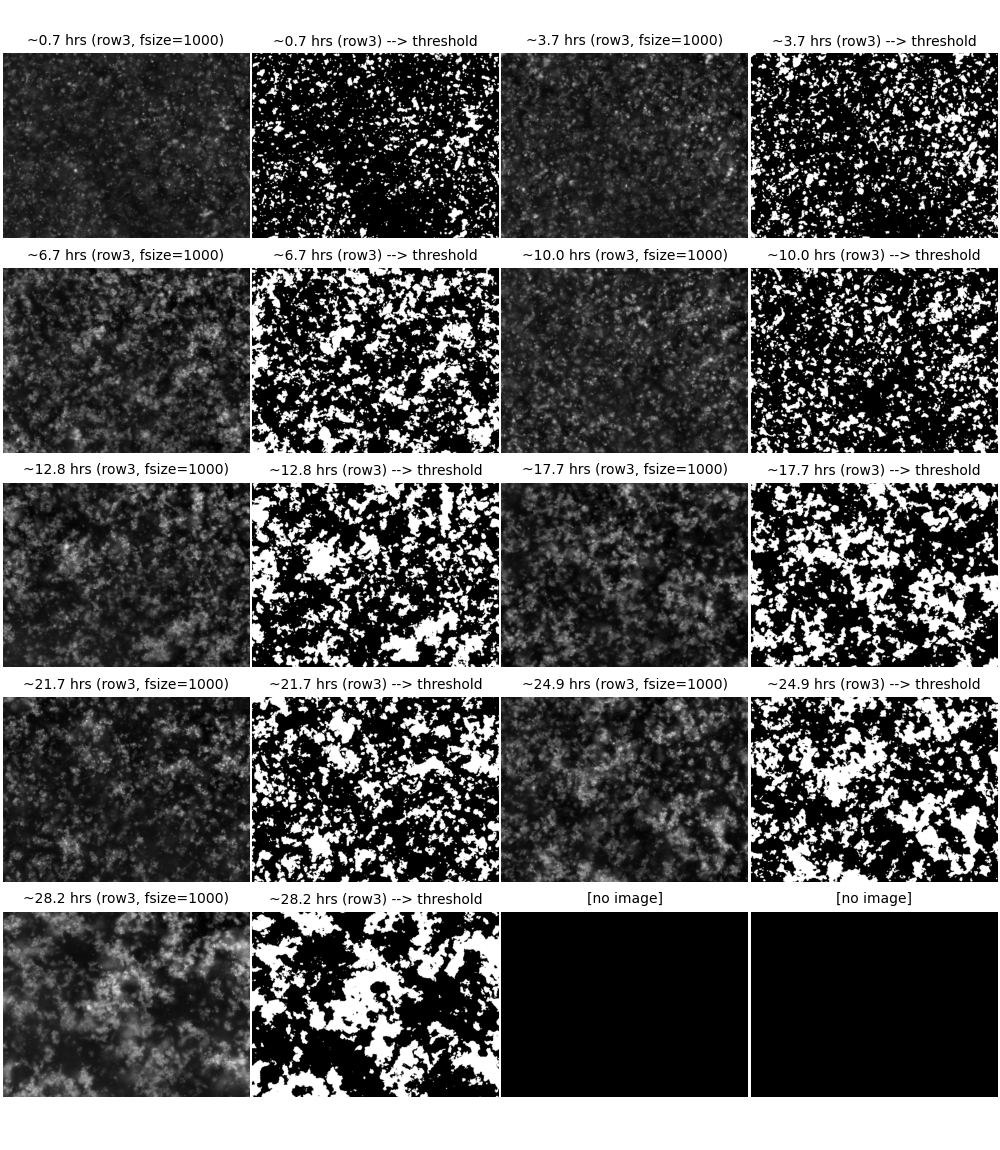

[0.7, 3.7, 6.7, 10.0, 12.8, 17.7, 21.7, 24.9, 28.2]


In [88]:
frame_key = 2
### "frame_key" specifies which frame of each tiff file will be analyzed (each frame of my tiff is for a different condition)
### e.g. "key = 0" dictates that the first frame of each tiff file should be analyzed
condition = frame_names[frame_key]
print("condition: "+condition)

fsize = 1000
filt = True
### set filter size (pixel area used to estimate and remove average background pixel intensities, recommendation = 600
if filt == False:
    fil = "none" 
else:
    fil = str(fsize)

row = 3
### choose which set of tiff files should be analyzed, row1, row2 or row3

fig_height = num_rows*2.3
time_array.append(0)
print(time_array)
i = 0
fig, axs = plt.subplots(num_rows, 4, figsize=(10,fig_height))
for j, ax in enumerate(axs.flatten()):
    if j % 2 == 0:
        show_filtered_images(fsize, row, ax, i, frame_key, filt)
    else:
        show_threshold_images(fsize, row, ax, i, frame_key, filt)
        i = i + 1 
plt.show()
time_array.remove(0)
print(time_array)

### option to save this figure (uncomment below)
fig.savefig(saveto_dir+"n threshold vs filtered images for "+condition+" (row"+str(row)+", f="+fil+")"+".jpg", dpi=dpi_num)

In [96]:
row1_thresh = [0.0] * int(arr_length)
row2_thresh = [0.0] * int(arr_length)
row3_thresh = [0.0] * int(arr_length)

row1_results = [0.0] * int(arr_length)
row2_results = [0.0] * int(arr_length)
row3_results = [0.0] * int(arr_length)
print("condition: "+condition)
print("fsize= "+fil)

beads_per_cluster = 5
size_lim = int( (beads_per_cluster*0.785) / (pixel_size**2) ) + 2 #add 2 to round up just for good measure (i.e. 473+2=475)     
### 2D bead area = pi*(0.5 um)^2 = 0.785 um^2
# e.g (5 beads)(0.785 um^2) = 3.93 um^2 ---> (3.93 um^2)/((0.091 um/px)^2) = ~475 pixels^2
print("define clusters as at least: "+str(beads_per_cluster)+" beads --> size_lim = "+str(size_lim)+" pixels^2")

condition: EA KaiC
fsize= 1000
define clusters as at least: 5 beads --> size_lim = 475 pixels^2


In [90]:
#frame_key = 0
cmap = matplotlib.cm.get_cmap('Greens')

return_marked = True
for i in range(arr_length):
    rows, cols, = rows_n_cols(tiff_file.imread(files[0], key=[frame_key]))
    
    row1_thresh[i] = threshold_images(fsize, tiff_file.imread(files[i],key=[frame_key]), i, return_marked, filt)
    row2_thresh[i] = threshold_images(fsize, tiff_file.imread(files[i+arr_length], key=[frame_key]), i, return_marked, filt) 
    row3_thresh[i] = threshold_images(fsize, tiff_file.imread(files[i+(arr_length*2)],key=[frame_key]), i, return_marked, filt) 
    
    r1_total_num, r1_mean_size, r1_median_size, r1_mode_size = cluster_analysis(size_lim, i, 1, row1_thresh[i], rows, cols)
    r2_total_num, r2_mean_size, r2_median_size, r2_mode_size = cluster_analysis(size_lim, i, 2, row2_thresh[i], rows, cols)
    r3_total_num, r3_mean_size, r3_median_size, r3_mode_size = cluster_analysis(size_lim, i, 3, row3_thresh[i], rows, cols)
    
    row1_results[i] = (r1_total_num, r1_mean_size, r1_median_size, r1_mode_size)
    row2_results[i] = (r2_total_num, r2_mean_size, r2_median_size, r2_mode_size)
    row3_results[i] = (r3_total_num, r3_mean_size, r3_median_size, r3_mode_size)

for row1, t= 0.7 hrs:
[476, 477, 479, 479, 480, 491, 497, 500, 501, 508, 508, 509, 509, 518, 518, 526, 527, 533, 537, 539, 540, 543, 552, 554, 555, 557, 571, 577, 578, 591, 596, 596, 598, 600, 601, 604, 605, 608, 612, 619, 623, 627, 632, 636, 638, 648, 655, 661, 664, 679, 681, 689, 692, 693, 697, 713, 716, 719, 724, 733, 733, 749, 751, 755, 760, 760, 762, 768, 768, 779, 780, 783, 812, 813, 815, 817, 832, 834, 836, 837, 847, 857, 865, 895, 897, 900, 906, 925, 926, 933, 947, 966, 971, 971, 974, 978, 979, 989, 994, 1002, 1012, 1048, 1056, 1076, 1077, 1092, 1122, 1148, 1153, 1155, 1170, 1173, 1174, 1213, 1254, 1263, 1284, 1289, 1327, 1332, 1337, 1350, 1377, 1377, 1412, 1416, 1417, 1428, 1455, 1484, 1496, 1496, 1522, 1534, 1537, 1542, 1581, 1585, 1623, 1657, 1704, 1717, 1722, 1729, 1801, 1810, 1820, 1827, 1846, 1902, 1908, 1913, 1920, 1924, 1934, 1956, 1966, 1967, 2036, 2092, 2104, 2104, 2108, 2117, 2117, 2144, 2162, 2254, 2262, 2272, 2379, 2432, 2442, 2521, 2560, 2647, 2663, 2685, 2724, 27

<IPython.core.display.Javascript object>


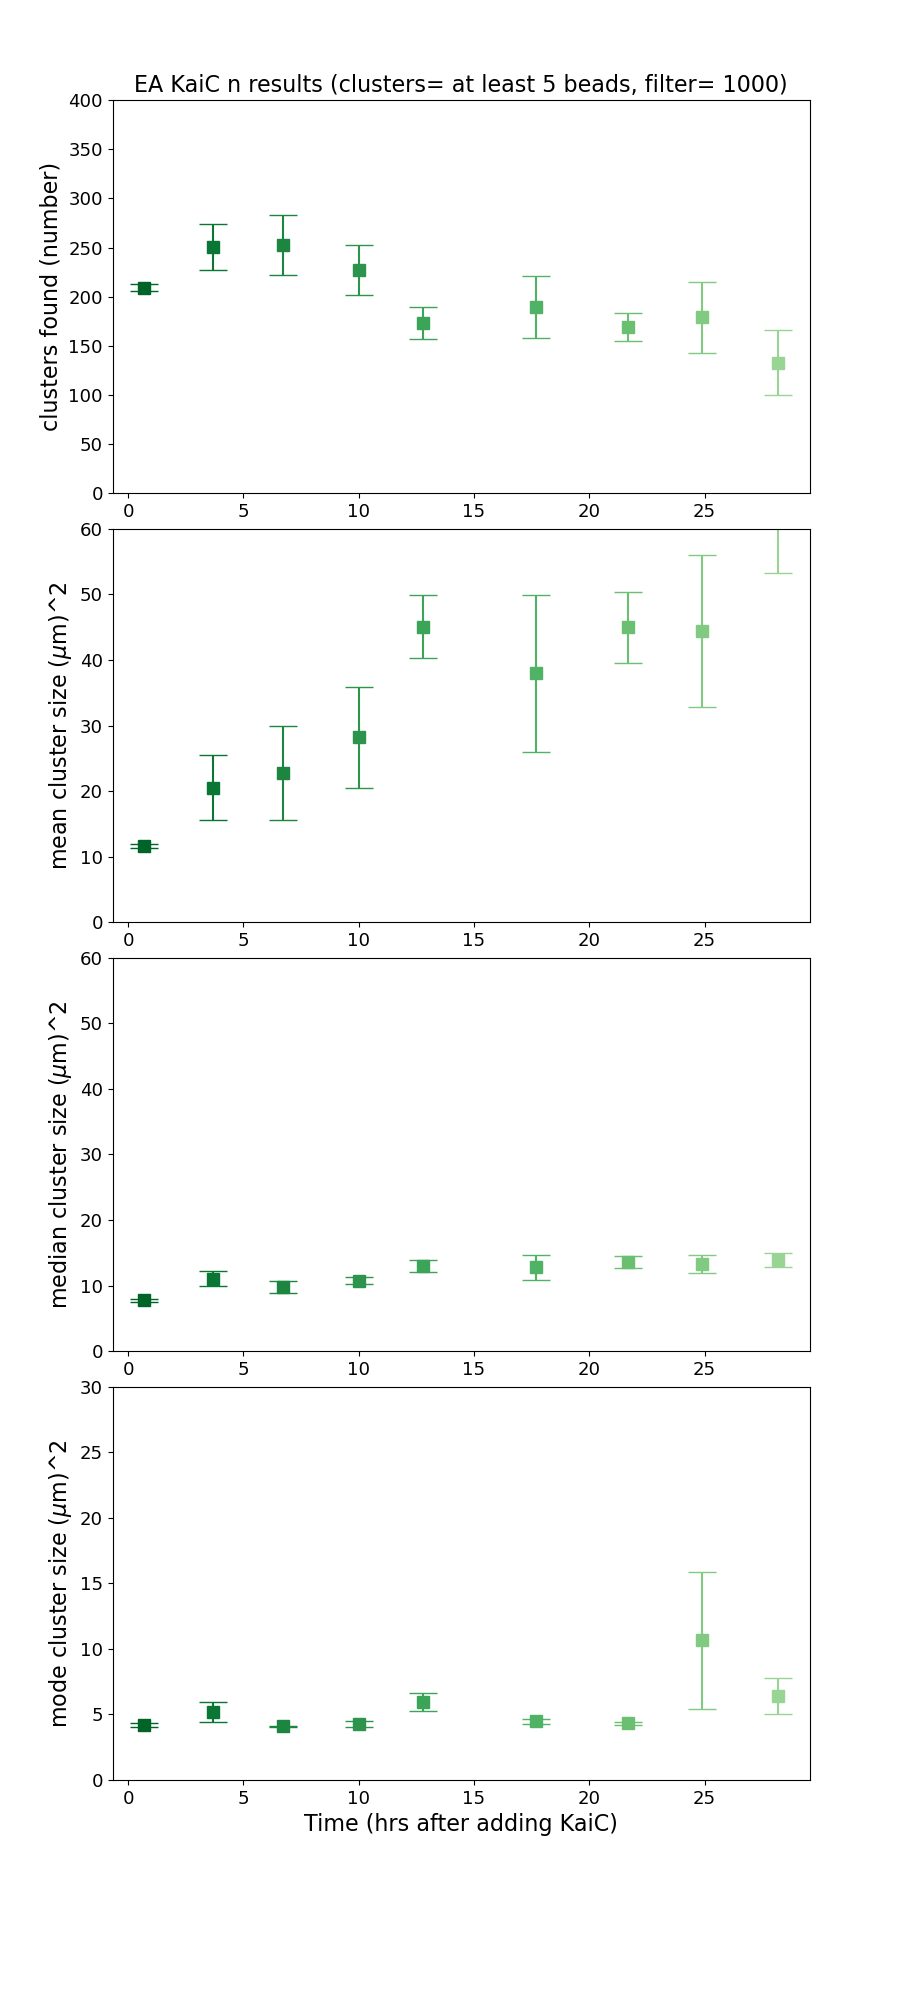

In [91]:
cmap_num = (arr_length*2) - 2
fig_size = 9, 20   #20/1.618

### set up empty arrays
all_total_num = np.zeros((3,len(row1_results)))
avg_total_num = np.empty(len(row1_results))
stderror_total_num = np.empty(len(row1_results))

### find average values and std. error 
for i in range(len(row1_results)):
    all_total_num[0,i] = row1_results[i][0]
    all_total_num[1,i] = row2_results[i][0]
    all_total_num[2,i] = row3_results[i][0]
avg_total_num = all_total_num.mean(axis=0)
stderror_total_num = all_total_num.std(axis=0)/np.sqrt(3)

### same process for the other output results
all_mean_size = np.zeros((3,len(row1_results)))
avg_mean_size = np.empty(len(row1_results))
stderror_mean_size = np.empty(len(row1_results))
for i in range(len(row1_results)):
    all_mean_size[0,i] = row1_results[i][1]
    all_mean_size[1,i] = row2_results[i][1]
    all_mean_size[2,i] = row3_results[i][1]
avg_mean_size = all_mean_size.mean(axis=0)
stderror_mean_size = all_mean_size.std(axis=0)/np.sqrt(3)

all_median_size = np.zeros((3,len(row1_results)))
avg_median_size = np.empty(len(row1_results))
stderror_median_size = np.empty(len(row1_results))
for i in range(len(row1_results)):
    all_median_size[0,i] = row1_results[i][2]
    all_median_size[1,i] = row2_results[i][2]
    all_median_size[2,i] = row3_results[i][2]
avg_median_size = all_median_size.mean(axis=0)
stderror_median_size = all_median_size.std(axis=0)/np.sqrt(3)

all_mode_size = np.zeros((3,len(row1_results)))
avg_mode_size = np.empty(len(row1_results))
stderror_mode_size = np.empty(len(row1_results))
for i in range(len(row1_results)):
    all_mode_size[0,i] = row1_results[i][3]
    all_mode_size[1,i] = row2_results[i][3]
    all_mode_size[2,i] = row3_results[i][3]
avg_mode_size = all_mode_size.mean(axis=0)
stderror_mode_size = all_mode_size.std(axis=0)/np.sqrt(3)

### plot average values and std. error for L1 correlation lengths
fig = plt.figure(figsize=(fig_size))
gs = fig.add_gridspec(4, top=0.95, hspace=0.09)
axs = gs.subplots(sharex=False, sharey=False)
#fig, axs = plt.subplots(3, figsize=(fig_size))
markerSize = 8
title = condition +" n results (clusters= at least "+str(beads_per_cluster)+" beads, filter= "+fil+")"

for i in range(int(len(time_array))):
    axs[0].set_title(title, fontsize= (font_size))
    axs[0].set( ylabel='clusters found (number)')
    axs[0].set_ylim(0, 400)
    axs[0].plot(time_array[i], avg_total_num[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label = "max cluster size")
    axs[0].errorbar(time_array[i], avg_total_num[i], yerr = stderror_total_num[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
    axs[1].set( ylabel='mean cluster size ($\mu$m)^2')
    axs[1].set_ylim(0, 60)
    axs[1].plot(time_array[i], avg_mean_size[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label = "mean cluster size")
    axs[1].errorbar(time_array[i], avg_mean_size[i], yerr = stderror_mean_size[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
    axs[2].set( ylabel='median cluster size ($\mu$m)^2')
    axs[2].set_ylim(0, 60)
    axs[2].plot(time_array[i], avg_median_size[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label = "mean cluster size")
    axs[2].errorbar(time_array[i], avg_median_size[i], yerr = stderror_median_size[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
    axs[3].set( ylabel='mode cluster size ($\mu$m)^2')
    axs[3].set( xlabel="Time (hrs after adding KaiC)")
    axs[3].set_ylim(0, 30)
    axs[3].plot(time_array[i], avg_mode_size[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label = "mean cluster size")
    axs[3].errorbar(time_array[i], avg_mode_size[i], yerr = stderror_mode_size[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=(font_size-3))
    ax.xaxis.get_label().set_fontsize(font_size)
    ax.yaxis.get_label().set_fontsize(font_size)

#plt.subplot_tool()
plt.show()
fig.savefig(saveto_dir+title+".jpg", dpi=dpi_num)

In [92]:
csv_data_file = exp+"-- results (clusters= at least "+str(beads_per_cluster)+" beads, filter= "+fil+")"+".csv"
data_file_exists = os.path.isfile(saveto_dir+csv_data_file)
if data_file_exists:
    print("Data file already exists.")
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([title])
        writer.writerow(['clusters detected','','','','','',
                         'max cluster size','','','','','',
                         'mean cluster size','','','','','',
                         'avg clustering of a pixel',''])
        writer.writerow(['time (hrs)',
                         'row1','row2','row3','avg','std error','',
                         'row1','row2','row3','avg','std error','',
                         'row1','row2','row3','avg','std error','',
                         'row1','row2','row3','avg','std error'])
        for i in range(len(time_array)):
            writer.writerow([time_array[i], 
                             row1_results[i][0], row2_results[i][0], row3_results[i][0], 
                             avg_total_num[i], stderror_total_num[i], '',
                             row1_results[i][1], row2_results[i][1], row3_results[i][1], 
                             avg_mean_size[i], stderror_mean_size[i], '',
                             row1_results[i][2], row2_results[i][2], row3_results[i][2], 
                             avg_median_size[i], stderror_median_size[i], '', 
                             row1_results[i][3], row2_results[i][3], row3_results[i][3], 
                             avg_mode_size[i], stderror_mode_size[i]])
        writer.writerow([''])
        writer.writerow([''])
    f.close()
    print("Results appended to file.")
else:
    print("Data file does NOT exist.")
    header = []
    np.savetxt(saveto_dir+csv_data_file, header, fmt="%s", delimiter=',')
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([title])
        writer.writerow(['clusters detected','','','','','',
                         'max cluster size','','','','','',
                         'mean cluster size','','','','','',
                         'avg clustering of a pixel',''])
        writer.writerow(['time (hrs)',
                         'row1','row2','row3','avg','std error','',
                         'row1','row2','row3','avg','std error','',
                         'row1','row2','row3','avg','std error','',
                         'row1','row2','row3','avg','std error'])
        for i in range(len(time_array)):
            writer.writerow([time_array[i], 
                             row1_results[i][0], row2_results[i][0], row3_results[i][0], 
                             avg_total_num[i], stderror_total_num[i], '',
                             row1_results[i][1], row2_results[i][1], row3_results[i][1], 
                             avg_mean_size[i], stderror_mean_size[i], '',
                             row1_results[i][2], row2_results[i][2], row3_results[i][2], 
                             avg_median_size[i], stderror_median_size[i], '', 
                             row1_results[i][3], row2_results[i][3], row3_results[i][3], 
                             avg_mode_size[i], stderror_mode_size[i]])
        writer.writerow([''])
        writer.writerow([''])
    f.close()
    print("New csv created, results appended to file.")

Data file already exists.
Results appended to file.


In [93]:
csv_data_file = exp+"--BP results (clusters= at least "+str(beads_per_cluster)+" beads, filter= "+fil+")"+".csv"
data_file_exists = os.path.isfile(saveto_dir+csv_data_file)
if data_file_exists:
    print("Data file already exists.")
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(['condition:','',title])
        writer.writerow(['clusters detected','','','','','','','','','','','',
                         'mean cluster size','','','','','','','','','','','',
                         'median cluster size','','','','','','','','','','','',
                         'mode cluster size','','','','','','','','','','','',])
        writer.writerow(['time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',])
        
        writer.writerow(['row1',row1_results[1][0],row1_results[2][0],row1_results[3][0],row1_results[4][0],row1_results[5][0],
                         row1_results[6][0],row1_results[7][0],row1_results[8][0],row1_results[i][0],'','',
                         'row1',row1_results[1][1],row1_results[2][1],row1_results[3][1],row1_results[4][1],row1_results[5][1],
                         row1_results[6][1],row1_results[7][1],row1_results[8][1],row1_results[i][1],'','',
                         'row1',row1_results[1][2],row1_results[2][2],row1_results[3][2],row1_results[4][2],row1_results[5][2],
                         row1_results[6][2],row1_results[7][2],row1_results[8][2],row1_results[i][2],'','',
                         'row1',row1_results[1][3],row1_results[2][3],row1_results[3][3],row1_results[4][3],row1_results[5][3],
                         row1_results[6][3],row1_results[7][3],row1_results[8][3],row1_results[i][3],'','',])
        
        writer.writerow(['row2',row2_results[1][0],row2_results[2][0],row2_results[3][0],row2_results[4][0],row2_results[5][0],
                         row2_results[6][0],row2_results[7][0],row2_results[8][0],row2_results[i][0],'','',
                         'row2',row2_results[1][1],row2_results[2][1],row2_results[3][1],row2_results[4][1],row2_results[5][1],
                         row2_results[6][1],row2_results[7][1],row2_results[8][1],row2_results[i][1],'','',
                         'row2',row2_results[1][2],row2_results[2][2],row2_results[3][2],row2_results[4][2],row2_results[5][2],
                         row2_results[6][2],row2_results[7][2],row2_results[8][2],row2_results[i][2],'','',
                         'row2',row2_results[1][3],row2_results[2][3],row2_results[3][3],row2_results[4][3],row2_results[5][3],
                         row2_results[6][3],row2_results[7][3],row2_results[8][3],row2_results[i][3],'','',])
        
        writer.writerow(['row3',row3_results[1][0],row3_results[2][0],row3_results[3][0],row3_results[4][0],row3_results[5][0],
                         row3_results[6][0],row3_results[7][0],row3_results[8][0],row3_results[i][0],'','',
                         'row3',row3_results[1][1],row3_results[2][1],row3_results[3][1],row3_results[4][1],row3_results[5][1],
                         row3_results[6][1],row3_results[7][1],row3_results[8][1],row3_results[i][1],'','',
                         'row3',row3_results[1][2],row3_results[2][2],row3_results[3][2],row3_results[4][2],row3_results[5][2],
                         row3_results[6][2],row3_results[7][2],row3_results[8][2],row3_results[i][2],'','',
                         'row3',row3_results[1][3],row3_results[2][3],row3_results[3][3],row3_results[4][3],row3_results[5][3],
                         row3_results[6][3],row3_results[7][3],row3_results[8][3],row3_results[i][3],'','',])
        writer.writerow([''])
        writer.writerow([''])
    f.close()
    print("Results appended to file.")
else:
    print("Data file does NOT exist.")
    header = []
    np.savetxt(saveto_dir+csv_data_file, header, fmt="%s", delimiter=',')
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(['condition:','',title])
        writer.writerow(['clusters detected','','','','','','','','','','','',
                         'mean cluster size','','','','','','','','','','','',
                         'median cluster size','','','','','','','','','','','',
                         'mode cluster size','','','','','','','','','','','',])
        writer.writerow(['time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',])
        
        writer.writerow(['row1',row1_results[1][0],row1_results[2][0],row1_results[3][0],row1_results[4][0],row1_results[5][0],
                         row1_results[6][0],row1_results[7][0],row1_results[8][0],row1_results[i][0],'','',
                         'row1',row1_results[1][1],row1_results[2][1],row1_results[3][1],row1_results[4][1],row1_results[5][1],
                         row1_results[6][1],row1_results[7][1],row1_results[8][1],row1_results[i][1],'','',
                         'row1',row1_results[1][2],row1_results[2][2],row1_results[3][2],row1_results[4][2],row1_results[5][2],
                         row1_results[6][2],row1_results[7][2],row1_results[8][2],row1_results[i][2],'','',
                         'row1',row1_results[1][3],row1_results[2][3],row1_results[3][3],row1_results[4][3],row1_results[5][3],
                         row1_results[6][3],row1_results[7][3],row1_results[8][3],row1_results[i][3],'','',])
        
        writer.writerow(['row2',row2_results[1][0],row2_results[2][0],row2_results[3][0],row2_results[4][0],row2_results[5][0],
                         row2_results[6][0],row2_results[7][0],row2_results[8][0],row2_results[i][0],'','',
                         'row2',row2_results[1][1],row2_results[2][1],row2_results[3][1],row2_results[4][1],row2_results[5][1],
                         row2_results[6][1],row2_results[7][1],row2_results[8][1],row2_results[i][1],'','',
                         'row2',row2_results[1][2],row2_results[2][2],row2_results[3][2],row2_results[4][2],row2_results[5][2],
                         row2_results[6][2],row2_results[7][2],row2_results[8][2],row2_results[i][2],'','',
                         'row2',row2_results[1][3],row2_results[2][3],row2_results[3][3],row2_results[4][3],row2_results[5][3],
                         row2_results[6][3],row2_results[7][3],row2_results[8][3],row2_results[i][3],'','',])
        
        writer.writerow(['row3',row3_results[1][0],row3_results[2][0],row3_results[3][0],row3_results[4][0],row3_results[5][0],
                         row3_results[6][0],row3_results[7][0],row3_results[8][0],row3_results[i][0],'','',
                         'row3',row3_results[1][1],row3_results[2][1],row3_results[3][1],row3_results[4][1],row3_results[5][1],
                         row3_results[6][1],row3_results[7][1],row3_results[8][1],row3_results[i][1],'','',
                         'row3',row3_results[1][2],row3_results[2][2],row3_results[3][2],row3_results[4][2],row3_results[5][2],
                         row3_results[6][2],row3_results[7][2],row3_results[8][2],row3_results[i][2],'','',
                         'row3',row3_results[1][3],row3_results[2][3],row3_results[3][3],row3_results[4][3],row3_results[5][3],
                         row3_results[6][3],row3_results[7][3],row3_results[8][3],row3_results[i][3],'','',])
        writer.writerow([''])
        writer.writerow([''])
    f.close()
    print("New csv created, results appended to file.")

Data file already exists.
Results appended to file.
